# Deep Unfolding

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch.optim as optim
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

from MNIST_dataloader import *
from Fast_MRI_dataloader import *

In [2]:
USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cuda


MNIST DATASET PREPERATION

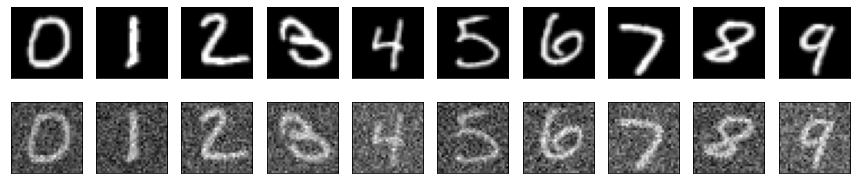

In [3]:
# define parameters
data_loc = 'MNIST Datasets' #change the datalocation to something that works for you
batch_size = 64

# get dataloader
train_loader, test_loader = create_dataloaders_MNIST(data_loc, batch_size)

# get some examples
examples = enumerate(test_loader)
_, (x_clean_example, x_noisy_example, labels_example) = next(examples)
# use these example images througout the assignment as the first 10 correspond to the digits 0-9

# show the examples in a plot
plt.figure(figsize=(12,3))
for i in range(10):
    plt.subplot(2,10,i+1)
    plt.imshow(x_clean_example[i,0,:,:],cmap='gray')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(2,10,i+11)
    plt.imshow(x_noisy_example[i,0,:,:],cmap='gray')
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
# plt.savefig("data_examples.png", dpi=300, bbox_inches='tight')
# plt.show()

In [4]:
# Creating the test set and train set
x_clean_train = train_loader.dataset.Clean_Images
x_noisy_train = train_loader.dataset.Noisy_Images
labels_train  = train_loader.dataset.Labels

x_clean_test  = test_loader.dataset.Clean_Images
x_noisy_test  = test_loader.dataset.Noisy_Images
labels_test   = test_loader.dataset.Labels

# use these 10 examples as representations for all digits
x_clean_example = x_clean_test[0:10,:,:,:]
x_noisy_example = x_noisy_test[0:10,:,:,:]
labels_example = labels_test[0:10]


## Exercise 1 - ISTA
EXERCISE 1A

In [5]:
def soft_threshold(x, Lambda):
    return torch.sign(x) * torch.relu(torch.abs(x)-Lambda)

def ISTA(mu, Lambda, K, y):
    A = torch.eye(y.shape[1])
    x = torch.zeros((y.shape[0], y.shape[1]))
    for _ in tqdm(range(K)):
        y_new = y@(mu*A)      
        x_new = x@(torch.eye(y.shape[1])-mu*A@A.T)
        x = soft_threshold(y_new + x_new, Lambda)
    return x 

In [6]:
noisy_measurements = x_noisy_example
noisy_measurements = noisy_measurements.reshape(len(noisy_measurements), -1)  # flatten the input

# Parameter values for ISTA
mu = 1
Lambda = 1.3
K = 10

reconstructed_x = ISTA(mu, Lambda, K, noisy_measurements + 2)       # offset = 2 for better filtering

100%|██████████| 10/10 [00:00<00:00, 110.65it/s]


EXERCISE 1B



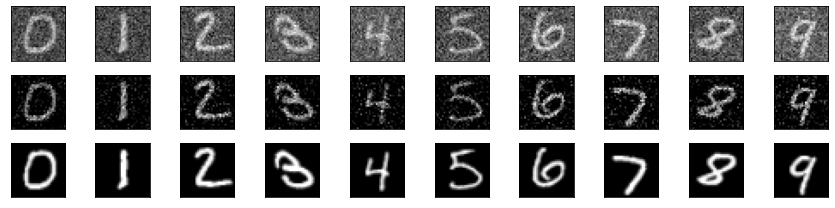

In [7]:
# show the examples in a plot
reconstructed_x = torch.reshape(reconstructed_x, (reconstructed_x.shape[0], 1, 32, 32))

plt.figure(figsize=(12,3))
for i in range(10):
    plt.subplot(3, 10, i+1)
    plt.imshow(x_noisy_example[i,0,:,:], cmap='gray')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(3, 10, i+11)
    plt.imshow(reconstructed_x[i,0,:,:], cmap='gray')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(3, 10, i+21)
    plt.imshow(x_clean_example[i,0,:,:], cmap='gray')
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
# plt.savefig("data_examples.png", dpi=100, bbox_inches='tight')
# plt.show()

In [8]:
# Showing range of output
print("Minimum value =", reconstructed_x.min().item())
print("Maximum value =", reconstructed_x.max().item())

Minimum value = 0.0
Maximum value = 3.3097918033599854


EXERCISE 1C

In [9]:
# Converting the tensor to numpy array of size N x 1024
x_noisy_test_flatten = x_noisy_test
x_noisy_test_flatten = x_noisy_test_flatten.reshape(len(x_noisy_test_flatten), -1)
reconstructed_x_test = ISTA(mu, Lambda, K, x_noisy_test_flatten)

# Calculating MSE Loss
mse_loss = nn.MSELoss()
reconstructed_x_test = reconstructed_x_test.reshape(len(reconstructed_x_test), 1, 32, 32)
rec_x_test_tensor = reconstructed_x_test
loss = mse_loss(rec_x_test_tensor, x_clean_test)
print('MSE loss for ISTA is', loss.item())


100%|██████████| 10/10 [00:01<00:00,  6.41it/s]

MSE loss for ISTA is 0.7743398547172546


## Exercise 2 - LISTA


EXERCISE 2A

In [10]:
def soft_threshold_LISTA(x, lamda):
    x = x + 0.5*(torch.sqrt(torch.pow(x-lamda, 2) + 1) - torch.sqrt(torch.pow(x+lamda, 2) + 1))
    return x

class ConvUnit(nn.Module):
    def __init__(self, conv1, conv2):
        super().__init__()
        self.conv1 = conv1
        self.conv2 = conv2
        self.lamda = Variable(torch.zeros(1), requires_grad=True)

    def forward(self, y, x):
        y_new = self.conv1(y)
        x_new = self.conv2(x)
        x_new = soft_threshold_LISTA(y_new + x_new, self.lamda.to(device=device))
        return x_new


class LISTA(nn.Module):
    def __init__(self, K):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 1, (5,5), padding=2, stride=1)
        self.conv2 = nn.Conv2d(1, 1, (5,5), padding=2, stride=1)
        self.list = nn.ModuleList([ConvUnit(self.conv1, self.conv2) for _ in range(K)])
    
    def forward(self, y):
        x = torch.zeros((y.shape[0], 1, 32 ,32)).to(device=device)
        for m in self.list:
            x = m(y, x)
        return x


In [11]:
# define training function
def train_LISTA(model, optimizer, epochs=1):
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in tqdm(range(epochs)):
        for _, (x, y, _) in enumerate(train_loader):
            model.train()  # put model to training mode
            y = y.to(device=device, dtype=torch.float32)
            x = x.to(device=device, dtype=torch.float32)
            scores = model(y)
            loss = F.mse_loss(scores, x)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

# train model
model = LISTA(3)

learning_rate = 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
epoch = 10

train_LISTA(model, optimizer, epoch)

# save model
PATH = os.path.join(os.getcwd(), "model_ex2.pt")
torch.save(model, PATH)

100%|██████████| 10/10 [01:38<00:00,  9.86s/it]


EXERCISE 2B

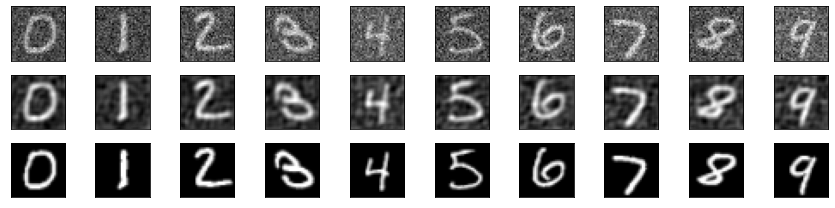

In [12]:
# load the model
PATH = os.path.join(os.getcwd(), "model_ex2.pt")
model_trained = torch.load(PATH)

# load the example data
noisy_measurements = x_noisy_example
reconstructed_x = torch.Tensor.cpu(model_trained(noisy_measurements.to(device=device))).detach().numpy()

# show the examples in a plot
plt.figure(figsize=(12,3))
for i in range(10):
    plt.subplot(3, 10, i+1)
    plt.imshow(x_noisy_example[i,0,:,:], cmap='gray')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(3, 10, i+11)
    plt.imshow(reconstructed_x[i,0,:,:], cmap='gray')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(3, 10, i+21)
    plt.imshow(x_clean_example[i,0,:,:], cmap='gray')
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.savefig("data_examples.png", dpi=100, bbox_inches='tight')
plt.show()

EXERCISE 2C

In [13]:
# Calculating MSE Loss
mse_loss = nn.MSELoss()

reconstructed_x = torch.Tensor.cpu(model_trained(x_noisy_test.to(device=device)))

loss = mse_loss(reconstructed_x, x_clean_test)
print('MSE loss for LISTA is', loss.item())

MSE loss for LISTA is 0.0416792593896389


EXERCISE 2D </br>
<font color=red> To be done!! </font>

## Exercise 3 - MRI helper functions

In [14]:
# define parameters
data_loc = 'Fast_MRI_Knee' #change the datalocation to something that works for you
batch_size = 2

train_loader_MRI, test_loader_MRI = create_dataloaders_MRI(data_loc, batch_size)

_, (partial_kspace, M, gt) = next(enumerate(test_loader_MRI))

EXERCISE 3A

In [15]:
def cal_full_kspace(gt):
    kspace = torch.fft.fftshift(torch.fft.fft2(gt), dim=-1)     # fft2 default: last two dimensions
    kspace = torch.fft.fftshift(kspace, dim=-2)
    return kspace

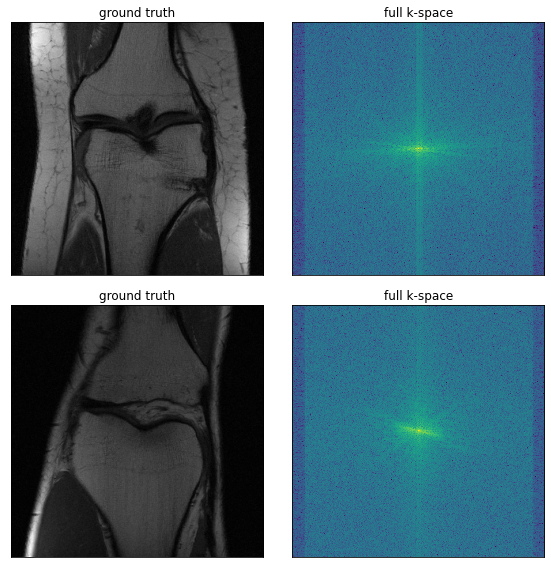

In [16]:
full_kspace = cal_full_kspace(gt)
full_kspace_plot_friendly = torch.log(torch.abs(full_kspace[0:2,:,:])+1e-20)

plt.figure(figsize = (8,8))
for i in range(batch_size):
    plt.subplot(batch_size,2,i*2+1)
    plt.imshow(gt[i,:,:],cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title('ground truth')

    plt.subplot(batch_size,2,(i+1)*2)
    plt.imshow(full_kspace_plot_friendly[i,:,:],vmin=-2.3,interpolation='nearest')
    plt.xticks([])
    plt.yticks([])
    plt.title('full k-space')
plt.tight_layout()

EXERCISE 3B

In [17]:
def cal_part_kspace(full_kspace, M):
    return M * full_kspace

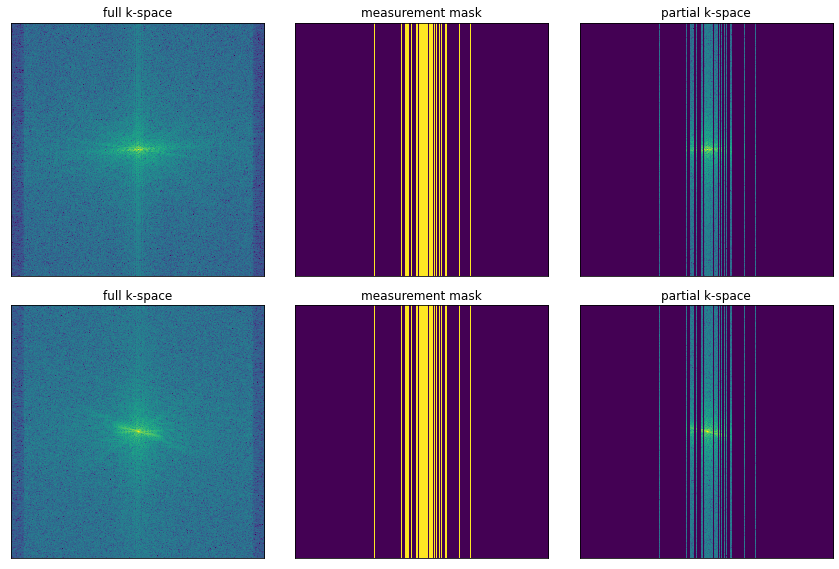

In [18]:
part_kspace = cal_part_kspace(full_kspace, M)
part_kspace_plot_friendly = torch.log(torch.abs(part_kspace[0:2,:,:])+1e-20)

plt.figure(figsize = (12,8))
for i in range(batch_size):
    plt.subplot(batch_size,3,i*3+1)
    plt.imshow(full_kspace_plot_friendly[i,:,:],vmin=-2.3,interpolation='nearest')
    plt.xticks([])
    plt.yticks([])
    plt.title('full k-space')

    plt.subplot(batch_size,3,i*3+2)
    plt.imshow(M[i,:,:],interpolation='nearest')
    plt.xticks([])
    plt.yticks([])
    plt.title('measurement mask')

    plt.subplot(batch_size,3,i*3+3)
    plt.imshow(part_kspace_plot_friendly[i,:,:],vmin=-2.3,interpolation='nearest')
    plt.xticks([])
    plt.yticks([])
    plt.title('partial k-space')
plt.tight_layout()


EXERCISE 3C

In [6]:
def cal_acc_MRI(part_kspace):
    acc = torch.fft.ifft2(part_kspace)           # ifft2 default: last two dimensions
    return acc

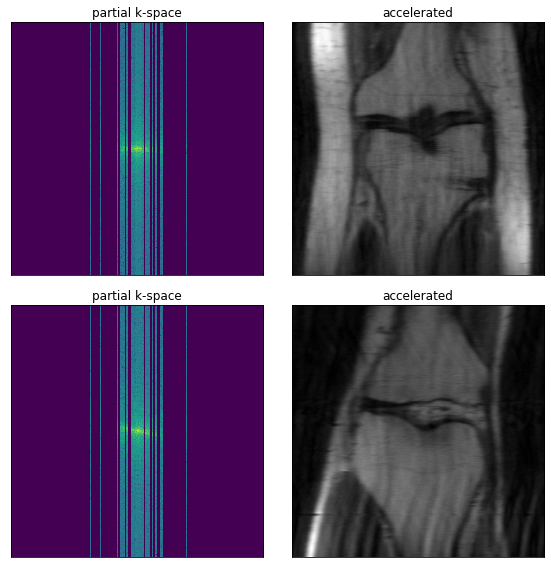

In [20]:
acc_MRI = cal_acc_MRI(part_kspace)
acc_MRI_plot_friendly = torch.abs(acc_MRI[0:2,:,:])

plt.figure(figsize = (8,8))
for i in range(batch_size):
    plt.subplot(batch_size,2,i*2+1)
    plt.imshow(part_kspace_plot_friendly[i,:,:],vmin=-2.3,interpolation='nearest')
    plt.xticks([])
    plt.yticks([])
    plt.title('partial k-space')

    plt.subplot(batch_size,2,i*2+2)
    plt.imshow(acc_MRI_plot_friendly[i,:,:],cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title('accelerated')
    
plt.tight_layout()

EXERCISE 3D

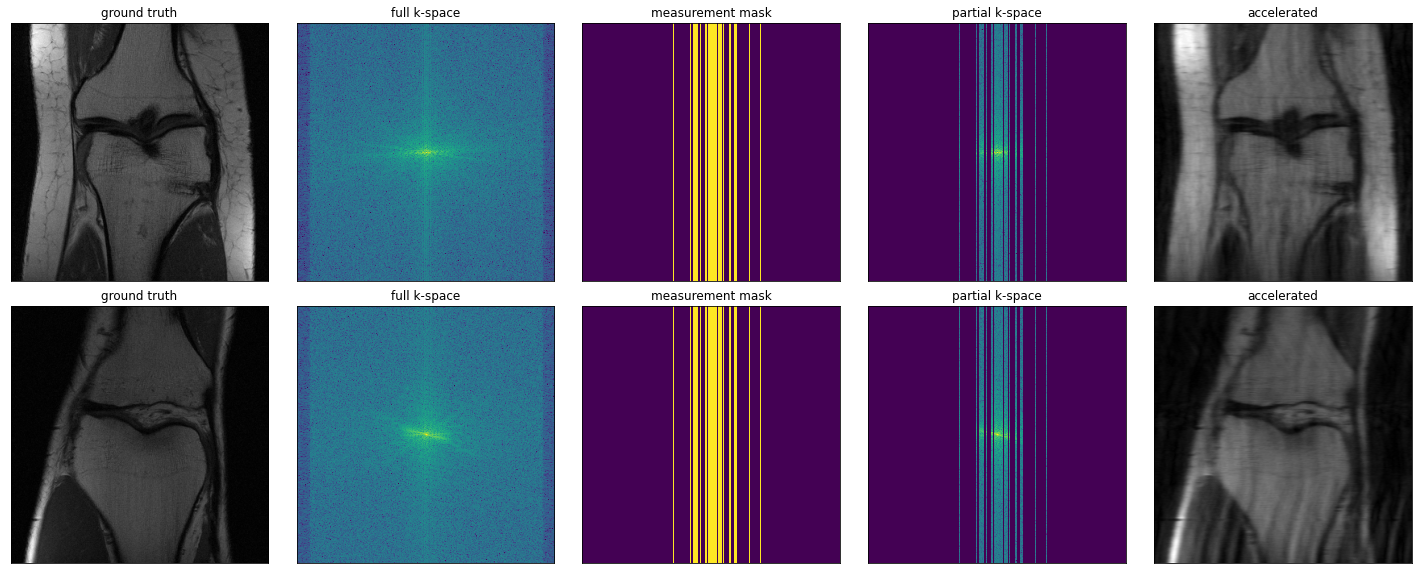

In [21]:
# plot the first batch example
part_kspace_plot_friendly = torch.log(torch.abs(part_kspace[0:batch_size,:,:])+1e-20)
full_kspace_plot_friendly = torch.log(torch.abs(full_kspace[0:batch_size,:,:])+1e-20)
acc_MRI_plot_friendly = torch.abs(acc_MRI[0:batch_size,:,:])

# # tune the value range
# for i in range(batch_size):
#     acc_MRI_plot_friendly[i] = acc_MRI_plot_friendly[i] * (gt[i,:,:].max() / acc_MRI_plot_friendly[i,:,:].max())

# # see value ranges
# print(gt[1,:,:].min(), gt[1,:,:].max())
# print(acc_MRI_plot_friendly[1,:,:].min(), acc_MRI_plot_friendly[1,:,:].max())

plt.figure(figsize = (20,8))
for i in range(batch_size):
    plt.subplot(batch_size,5,i*5+1)
    plt.imshow(gt[i,:,:],cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title('ground truth')

    plt.subplot(batch_size,5,i*5+2)
    plt.imshow(full_kspace_plot_friendly[i,:,:],vmin=-2.3,interpolation='nearest')
    plt.xticks([])
    plt.yticks([])
    plt.title('full k-space')

    plt.subplot(batch_size,5,i*5+3)
    plt.imshow(M[i,:,:],interpolation='nearest')
    plt.xticks([])
    plt.yticks([])
    plt.title('measurement mask')

    plt.subplot(batch_size,5,i*5+4)
    plt.imshow(part_kspace_plot_friendly[i,:,:],vmin=-2.3,interpolation='nearest')
    plt.xticks([])
    plt.yticks([])
    plt.title('partial k-space')

    plt.subplot(batch_size,5,i*5+5)
    plt.imshow(acc_MRI_plot_friendly[i,:,:],cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title('accelerated')
plt.tight_layout()

EXERCISE 3E </br>
<font color=red> To be done!! </font>

## Exercise 5 - ConvNet

In [3]:
# define parameters
data_loc = 'Fast_MRI_Knee' #change the datalocation to something that works for you
batch_size = 32

train_loader_MRI_ex5, test_loader_MRI_ex5 = create_dataloaders_MRI(data_loc, batch_size)

_, (partial_kspace, M, gt) = next(enumerate(test_loader_MRI_ex5))

EXERCISE 5A </br>
<font color=red> To be done!! </font>

EXERCISE 5B

In [4]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.convnet = nn.Sequential(           # input_size = N * 1 * 320 * 320
            nn.Conv2d(1, 16, 5, padding = 2),    # output_size = N * 16 * 320 * 320
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 64, 5, padding = 2),    # output_size = N * 64 * 320 * 320
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 16, 5, padding = 2),    # output_size = N * 16 * 320 * 320
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 1, 5, padding = 2),    # output_size = N * 1 * 320 * 320
        )
        
    def forward(self, x):
        scores = self.convnet(x)
        return scores

In [7]:
def cal_acc_MRI(part_kspace):
    acc = torch.fft.ifft2(part_kspace)           # ifft2 default: last two dimensions
    return acc

100%|██████████| 10/10 [01:30<00:00,  9.10s/it]


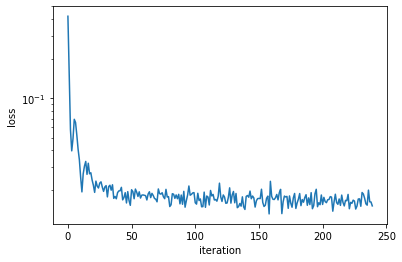

In [8]:
# _, (partial_kspace, M, gt) = next(enumerate(test_loader_MRI))

# define training function
def train_ConvNet(model, optimizer, epochs=1):
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    loss_list = []
    for e in tqdm(range(epochs)):
        for _, (y, _, x) in enumerate(train_loader_MRI_ex5):
            model.train()       # put model to training mode
            y = torch.abs(cal_acc_MRI(y))       # transfer partial_kspace into acc_MRI and get absolute value
            y = y.reshape(len(y), 1, y.shape[1], y.shape[2]).to(device=device, dtype=torch.float32)    
            x = x.reshape(len(x), 1, x.shape[1], x.shape[2]).to(device=device, dtype=torch.float32)
            scores = model(y)
            loss = F.mse_loss(scores, x)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_list.append(loss)
     
    plt.semilogy(loss_list)
    plt.xlabel('iteration')
    plt.ylabel('loss')

# train model
model = ConvNet()

learning_rate = 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
epoch = 10

train_ConvNet(model, optimizer, epoch)


# save model
PATH = os.path.join(os.getcwd(), "model_ex5.pt")
torch.save(model, PATH)

EXERCISE 5C

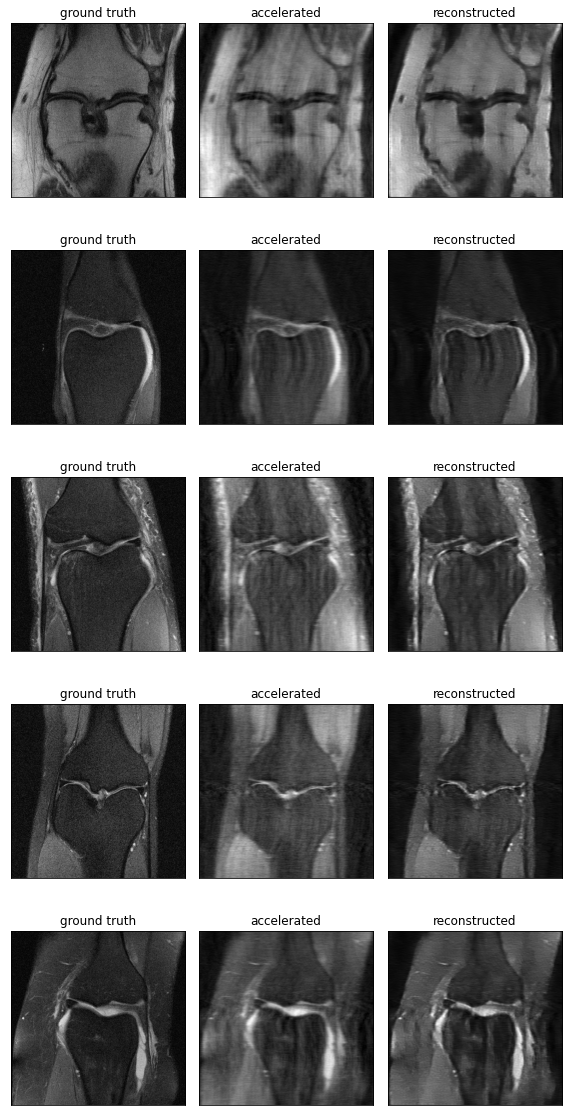

In [9]:
# load the model
PATH = os.path.join(os.getcwd(), "model_ex5.pt")
model_trained = torch.load(PATH)

# plot the first 5 examples
acc_MRI_plot_friendly = torch.abs(cal_acc_MRI(partial_kspace[0:5,:,:]))
reconstructed_MRI = torch.Tensor.cpu(model_trained(acc_MRI_plot_friendly.reshape(5, 1, 320, 320).to(device=device))).detach().numpy()
reconstructed_MRI = reconstructed_MRI.reshape(5, 320, 320)

plt.figure(figsize = (8,16))
for i in range(5):
    plt.subplot(5,3,i*3+1)
    plt.imshow(gt[i,:,:],cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title('ground truth')

    plt.subplot(5,3,i*3+2)
    plt.imshow(acc_MRI_plot_friendly[i,:,:],cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title('accelerated')

    plt.subplot(5,3,i*3+3)
    plt.imshow(reconstructed_MRI[i,:,:],cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title('reconstructed')
    
plt.tight_layout()

EXERCISE 5D </br>
(take a lot of time to transfer dataloader back to torch format and do calulation, can be modified by calculating per batch and also avoid memory problem)

In [12]:
# load the model
PATH = os.path.join(os.getcwd(), "model_ex5.pt")
model_trained = torch.load(PATH, map_location='cpu')    # using cpu to avoid memory shortage problem in gpu

# Creating the test set in torch format 
x_partial_kspace_test = []
x_gt_test = []
for i in range(test_loader_MRI_ex5.dataset.__len__()):
    test_kspace, _, test_gt = test_loader_MRI_ex5.dataset.__getitem__(i)
    x_partial_kspace_test.append(test_kspace)
    x_gt_test.append(test_gt)
x_partial_kspace_test = torch.tensor(np.array(x_partial_kspace_test))
x_gt_test = torch.tensor(np.array(x_gt_test))

# Calculating MSE Loss
mse_loss = nn.MSELoss()

test_input = (torch.abs(cal_acc_MRI(x_partial_kspace_test)).reshape(len(x_partial_kspace_test), 1, 320, 320))
reconstructed_MRI = model_trained(test_input)
reconstructed_MRI = reconstructed_MRI.reshape(len(reconstructed_MRI), 320, 320)

loss = mse_loss(reconstructed_MRI, x_gt_test)
print('MSE loss for ConvNet is', loss.item())

MSE loss for ConvNet is 0.013906849548220634


## Exercise 6 - Neural proximal gradient descent

EXERCISE 6A </br>
<font color=red> To be done!! </font>

EXERCISE 6B

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.convnet = nn.Sequential(           # input_size = N * 1 * 320 * 320
            nn.Conv2d(1, 16, 5, padding = 2),    # output_size = N * 16 * 320 * 320
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 64, 5, padding = 2),    # output_size = N * 64 * 320 * 320
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 16, 5, padding = 2),    # output_size = N * 16 * 320 * 320
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 1, 5, padding = 2),    # output_size = N * 1 * 320 * 320
        )
        
    def forward(self, x):
        scores = self.convnet(x)
        return scores

In [ ]:
class ProxUnit(nn.Module):
    def __init__(self, M, mu):      # A = M @ F
        super().__init__()
        self.M = M
        self.mu = mu
        self.P = ConvNet()

    def forward(self, y, x):
        y_new = torch.fft.ifft2(y @ self.M)
        x_new = x @ (torch.eye(y.shape[1]) - self.mu * self.M.T @ self.M)
        x_new = self.P(y_new + x_new)
        return x_new

class ProxNet(nn.Module):
    def __init__(self, K, M, mu):
        super().__init__()
        self.K = K
        self.M = M
        self.mu = mu
        self.list = nn.ModuleList([ProxUnit(self.M, self.mu) for _ in range(K)])
    
    def forward(self, y):
        x = torch.zeros((y.shape[0], 1, 320 ,320)).to(device=device)
        for m in self.list:
            x = m(y, x)
        return x
